In [1]:
import time
from typing import Iterable

import np as np
import torch
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
from cgtasknet.tasks.reduce import ReduceTaskCognitive


class EveryTaskSubgroups:
    device = torch.device("cpu")

    def __init__(
        self, model: torch.nn.Module, tasks: Iterable[ReduceTaskCognitive]
    ) -> None:
        self._tasks = tasks
        self._model = model
        self._subgroups_finder = None

    def run(self, number_of_trials: int, dt: float = 1e-3):
        self._subgroups_finder = []
        number_of_trials = int(number_of_trials)
        dt = float(dt)
        print("*" * 20, "Start")
        for current_task in self._tasks:
            t0 = time.perf_counter()
            self._subgroups_finder.append(SubgroupFinder(dt))
            for i in range(number_of_trials):
                status = False
                while not status:
                    inputs, t_outputs, s, out = self._run_trial(current_task)
                    status = self._subgroups_finder[-1].compute_average_freq(
                        [s.to(torch.device("cpu"))],
                        [inputs[:, 0, 0].to(torch.device("cpu"))],
                        [out.to(torch.device("cpu"))],
                        [t_outputs.to(torch.device("cpu"))],
                    )
            print(
                f"Complete task: {current_task.task_number}, time: {time.perf_counter() - t0}s"
            )

    def _run_trial(self, task: ReduceTaskCognitive):
        inputs, t_outputs = task.dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(self.device)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float).to(self.device)
        out, _, s = self._model(inputs)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        return inputs, t_outputs, s, out

    def get_frequencies(self):
        fixation = []
        answer = []
        for subgoup_finder in self._subgroups_finder:
            t_fixation, t_answer = subgoup_finder.get_average_freq()
            fixation.append(t_fixation)
            answer.append(t_answer)
        return fixation, answer

In [2]:
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
)
import matplotlib.pyplot as plt

In [3]:
go_task_list_values = np.linspace(0, 1, 8)

batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.2,
        positive_shift_delay_time=1.5,
        trial_time=0.2,
        positive_shift_trial_time=0.4,
        answer_time=0.25,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.5, answer_time=0.25)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=0.25,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        answer_time=1.5,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(
            trial_time=0.2,
            positive_shift_trial_time=0.4,
            answer_time=0.25,
            value=go_task_list_values,
        ),
        delay=0.2,
        positive_shift_delay_time=1.5,
    )
)
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}

tasks_sequence = [
    MultyReduceTasks(
        tasks=task_dict,
        batch_size=batch_size,
        delay_between=0,
        enable_fixation_delay=True,
        task_number=i,
    )
    for i in range(len(tasks))
]

In [4]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 256

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.65),
    tau_ada_inv=0.5,
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=50,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        r"A:\src\multy_task\models\low_freq\bound_and_square_after\weights\weights_100_N_256_1999_"
    )
)

<All keys matched successfully>

In [5]:
from sklearn.cluster import KMeans

subgroups = EveryTaskSubgroups(model, tasks_sequence)

subgroups.device = device
fixations, answers = [], []
for i in range(100):
    subgroups.run(1)
    fix, ans = subgroups.get_frequencies()
    fixations.append(
        [el.detach().cpu().numpy() if el is not None else None for el in fix]
    )
    answers.append([el.detach().cpu().numpy() for el in ans])

******************** Start
Complete task: 0, time: 3.0296655999999977s
Complete task: 1, time: 1.3969994000000021s
Complete task: 2, time: 0.8949829000000022s
Complete task: 3, time: 0.9538547000000008s
Complete task: 4, time: 0.6600119000000007s
Complete task: 5, time: 3.6869113999999996s
Complete task: 6, time: 1.7496385999999973s
Complete task: 7, time: 7.1316989000000035s
Complete task: 8, time: 1.8632683999999955s
Complete task: 9, time: 0.8758554000000061s
Complete task: 10, time: 1.7177352s
Complete task: 11, time: 1.409423199999999s
******************** Start
Complete task: 0, time: 1.0183397999999997s
Complete task: 1, time: 1.3707815999999937s
Complete task: 2, time: 0.7852931000000041s
Complete task: 3, time: 0.5917614999999969s
Complete task: 4, time: 1.2042793999999972s
Complete task: 5, time: 1.4820095000000038s
Complete task: 6, time: 2.1117466000000036s
Complete task: 7, time: 2.8070783000000006s
Complete task: 8, time: 2.343418800000002s
Complete task: 9, time: 1.52717

KeyboardInterrupt: 

In [6]:
answers_np = np.array(answers).T
answers_np = answers_np.reshape(
    answers_np.shape[-1] * answers_np.shape[-2], answers_np.shape[0]
).T
# indexes = np.where(answers_np.mean(axis=1) > 25)[0]
answers_np = np.concatenate(answers).T + 1
# answers_np = answers_np[indexes, :]
answers_np = (answers_np.T / np.sum(answers_np, axis=1)).T
print(answers_np.shape)

(256, 540)


In [7]:
print(answers_np.shape)

(256, 540)


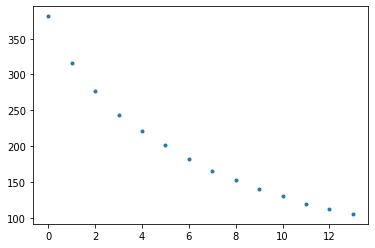

UsageError: Line magic function `%` not found.


In [8]:
X = np.concatenate(fixations, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 3
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

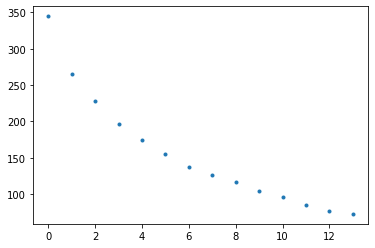

UsageError: Line magic function `%` not found.


In [9]:
X = np.concatenate(answers, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 2
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
X = np.concatenate(answers + fixations, axis=0).T / 2

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 2
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [259]:
np_variance = np.zeros((np_answers.shape[1], np_answers.shape[2]))
for i in range(np_answers.shape[-1]):
    np_variance[:, i] = np.sum(np_answers[:, :, i], axis=0) / 100

NameError: name 'np_answers' is not defined

In [ ]:
np_variance.shape

In [260]:
plt.imshow(np_variance / np_variance.max(), aspect="auto", cmap="jet", origin="lower")
plt.colorbar()

NameError: name 'np_variance' is not defined

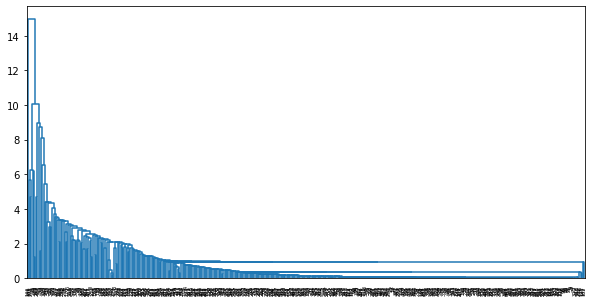

In [261]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(
    X
)  # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(
    distance_mat, "single"
)  # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=000)
plt.show()
plt.close()

In [262]:
X = np.concatenate(answers, axis=0).T
X = X[np.where(X.sum(axis=1) > 950)[0], :]
X.shape

(204, 1200)

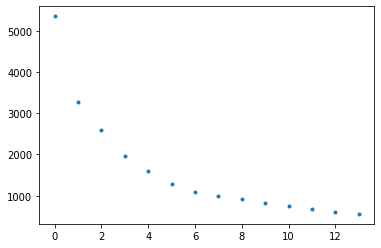

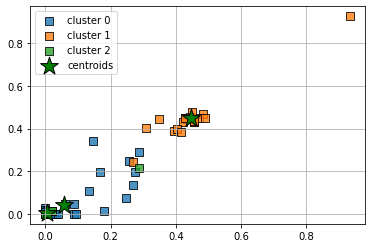

In [263]:
X = np.concatenate(answers, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 3
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

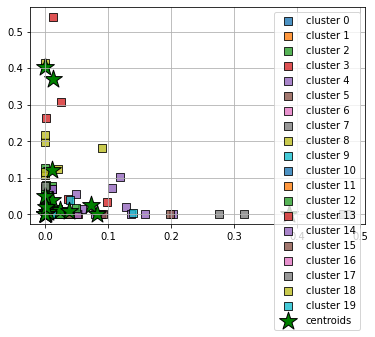

In [36]:
X = np.concatenate(answers, axis=0).T + np.concatenate(fixations, axis=0).T
X /= 2

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
n_clusters = 20
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.
# 00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [37]:
answers_np = np.array(answers) + np.array(fixations)
answers_np /= 2
tv = [answers_np[:, i, :].sum(axis=0) for i in range(answers_np.shape[1])]
tv = np.array(tv)
# tv = tv[np.where(tv.sum(axis=1) > 0)[0], :]
tv /= tv.max()
tv.shape

(12, 256)

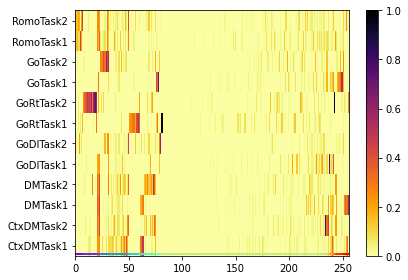

In [38]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another
from matplotlib import cm

sort_indexes = [*range(hidden_size)]
sort_indexes = sort_elemnts_by_another(tv[1], sort_indexes)
tv_sort = np.zeros_like(tv)
clusters = []
for i in range(n_clusters):
    clusters.extend(
        sort_elemnts_by_another(
            np.mean(tv[:, [*np.where(y_km == i)[0]]], axis=0), [*np.where(y_km == i)[0]]
        )
    )
cluster_sizes = []
for i in range(n_clusters):
    cluster_i = [*np.where(y_km == i)[0]]
    cluster_sizes.append(len(cluster_i))
for i in range(n_clusters):
    clusters.extend([*np.where(y_km == i)[0]])
clusters = clusters[::]
for task in range(len(tv)):
    for i in range(hidden_size):
        tv_sort[task, i] = tv[task, clusters[i]]
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="inferno_r", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
cluster_size = 0
# colors = ["#EF3B3B", "#233DFB", "#49FF00", "#F333FF", "#BF035B", "#23305F"]
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
for i in range(0, len(cluster_sizes)):
    plt.plot(
        [cluster_size, cluster_size + cluster_sizes[i]],
        [-0.4, -0.4],
        label=f"Cluster # {i + 1}",
        c=colors[i],
        linewidth=2,
    )
    # plt.plot([cluster_size ] * 2, [-1, len(tasks_couples)], c='black', linestyle='--', linewidth=.5)
    cluster_size += cluster_sizes[i]
# plt.legend()
plt.xlim(0, 256)
plt.colorbar()
plt.tight_layout()
plt.savefig("Clusters.png", dpi=1500)
plt.show()
plt.close()

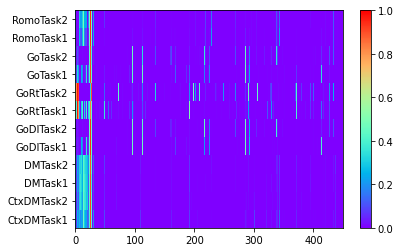

In [267]:
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="rainbow", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
# plt.xlim(0, 100)
plt.colorbar()
plt.show()
plt.close()

In [268]:
clusters = X = np.concatenate(fixations, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
n_clusters = 4
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()
answers_np = np.array(answers)
tv = [answers_np[:, i, :].sum(axis=0) for i in range(answers_np.shape[1])]
tv = np.array(tv)
# tv = tv[np.where(tv.sum(axis=1) > 0)[0], :]
tv /= tv.max()
tv.shape
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

sort_indexes = [*range(hidden_size)]
sort_indexes = sort_elemnts_by_another(tv[1], sort_indexes)
tv_sort = np.zeros_like(tv)
clusters = []
for i in range(n_clusters):
    clusters.extend([*np.where(y_km == i)[0]])
clusters = clusters[::-1]
for task in range(len(tv)):
    for i in range(hidden_size):
        tv_sort[task, i] = tv[task, clusters[i]]
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="rainbow", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
plt.xlim(0, 50)
plt.colorbar()
plt.show()
plt.close()
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="rainbow", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
# plt.xlim(0, 100)
plt.colorbar()
plt.show()
plt.close()

UsageError: Line magic function `%` not found.


In [ ]:
fixations[9][2]